# Importing Python libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from prettytable import PrettyTable

import plotly.graph_objs as go
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from scipy.stats import normaltest
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-success">  
    <h6>"</h6>
    <h6>"</h6>
    <h6>"</h6>
    <h6>"</h6>
    <h6>"</h6>
<h1><center><strong> TSLA Stock</strong></center></h1>
    <h6>"</h6>
    <h6>"</h6>
    <h6>"</h6>
    <h6>"</h6>
    <h6>"</h6>
        
</div>

# ------------------------------------------------------------------------------------------------------

# Loading dataset

In [4]:
data = pd.read_csv('TSLA_Stock.csv')

# -----------------------------------------------------------------------------------------------------------

<h1><center> Modelling Arima and Sarima</center></h1>

# -----------------------------------------------------------------------------------------------------------

### Seasonality of Close price

In [5]:
data['Close'] = data['Close'] * 1.0
close_1 = data['Close']
c = '#386B7F'

### Stationarize the Close price data

In [6]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [7]:
def residual_plot(model):
    resid = model.resid
    print(normaltest(resid))
    fig = plt.figure(figsize=(12,8))
    ax0 = fig.add_subplot(111)
    sns.distplot(resid ,fit = stats.norm, ax = ax0)
    (mu, sigma) = stats.norm.fit(resid)
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Residual distribution')
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(model.resid, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(model.resid, lags=40, ax=ax2)

### Close price with rolling windows

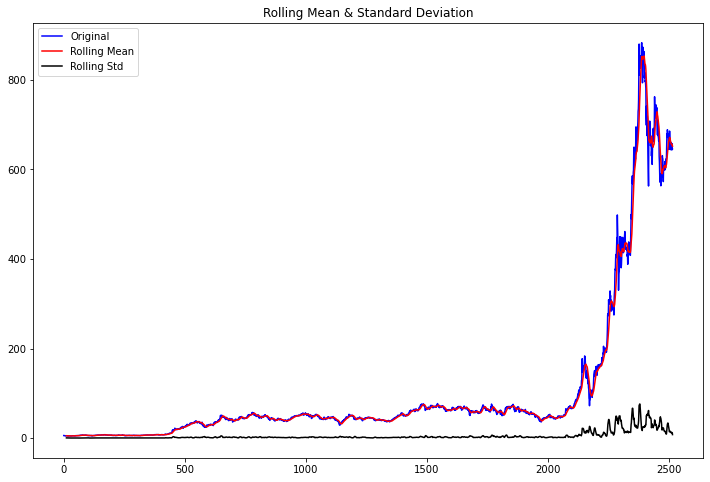

Results of Dickey-Fuller Test:
p-value = 0.9934. The series is likely non-stationary.
Test Statistic                    0.922403
p-value                           0.993376
#Lags Used                       19.000000
Number of Observations Used    2497.000000
Critical Value (1%)              -3.432972
Critical Value (5%)              -2.862698
Critical Value (10%)             -2.567387
dtype: float64


In [8]:
test_stationarity(close_1)

We are going to make data as stationary. So we want to do is take a first difference of the data and it will help to eliminate the overall trend from the data.

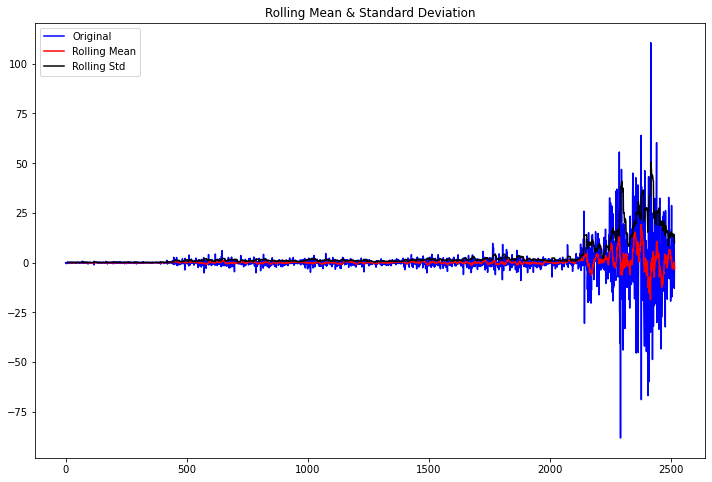

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -9.762858e+00
p-value                        7.482562e-17
#Lags Used                     2.000000e+01
Number of Observations Used    2.495000e+03
Critical Value (1%)           -3.432974e+00
Critical Value (5%)           -2.862699e+00
Critical Value (10%)          -2.567387e+00
dtype: float64


In [9]:
first_diff_a = close_1 - close_1.shift(1)
first_diff_a = first_diff_a.dropna(inplace = False)
test_stationarity(first_diff_a, window = 12)

### Plots of ACF and PACF

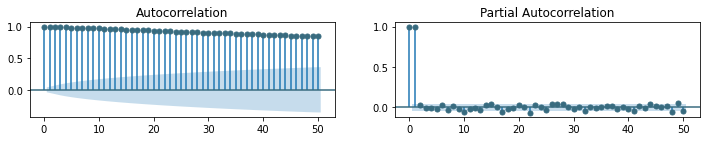

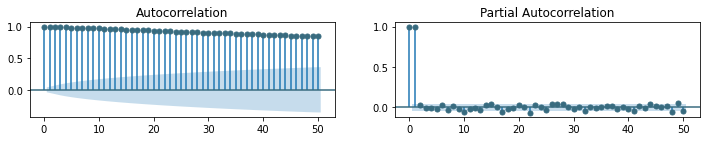

In [10]:
plt.figure(figsize = (12, 8))
plt.subplot(421); plot_acf(close_1, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(close_1, lags = 50, ax = plt.gca(), color = c)

### Splitting the data into training (first 70%) testing (latest 30%)

In [11]:
train_data, test_data = data[0:int(len(data)*0.7)], data[int(len(data)*0.7):]
training_data = train_data['Close'].values
test_data = test_data['Close'].values

### Training and testing the ARIMA model

In [12]:
history_of_train = [x for x in training_data]
predictions = []
test_records = len(test_data)
for times in range(test_records):
    arima = SARIMAX(history_of_train, order=(4,4,1))
    arima_fit = arima.fit(disp=0)
    output = arima_fit.forecast()
    pred = output[0]
    predictions.append(pred)
    test_value = test_data[times]
    history_of_train.append(test_value)

NormaltestResult(statistic=1084.9237278724163, pvalue=2.581106054566e-236)


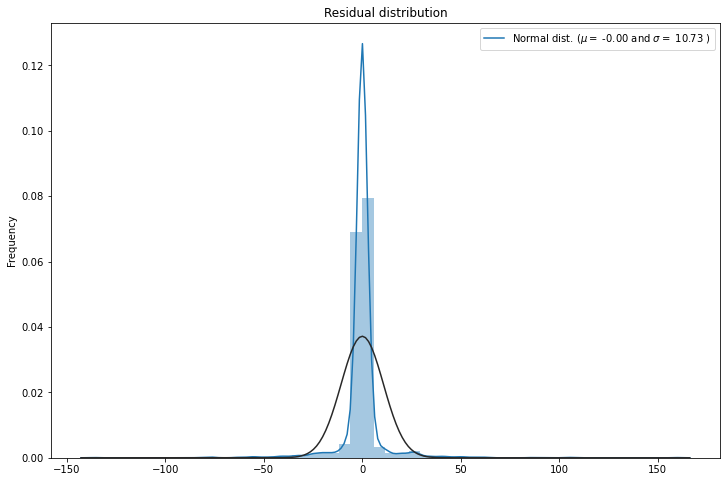

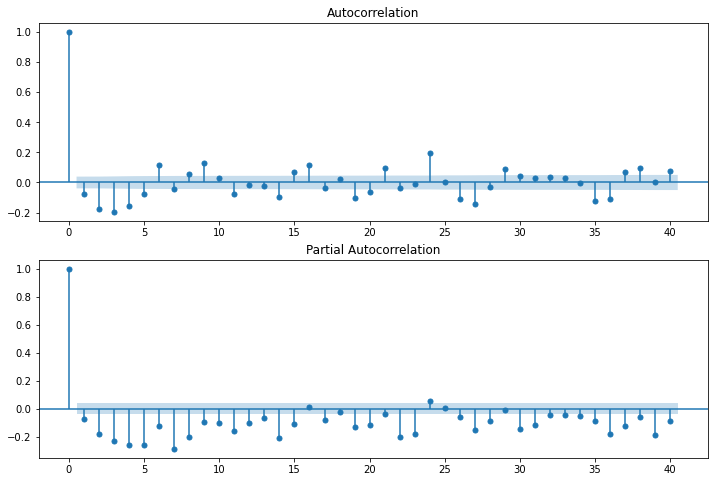

In [13]:
residual_plot(arima_fit)

### Evaluation of Arima Model on Test data

### R2

In [166]:
arima_test_rs=r2_score(test_data, predictions)
print('R Squared : ', round(arima_test_rs,3))

R Squared :  0.821


### MSE

In [167]:
arima_test_mse=mean_squared_error(test_data, predictions)
print('Mean Squared Error: ', round(arima_test_mse,3))

Mean Squared Error:  1236.471


### MAE

In [168]:
arima_test_MAE=mean_absolute_error(test_data, predictions)
print('Mean Absolute Error: ', round(arima_test_MAE,3))

Mean Absolute Error:  25.451


### Predictions and Actual Stock Price

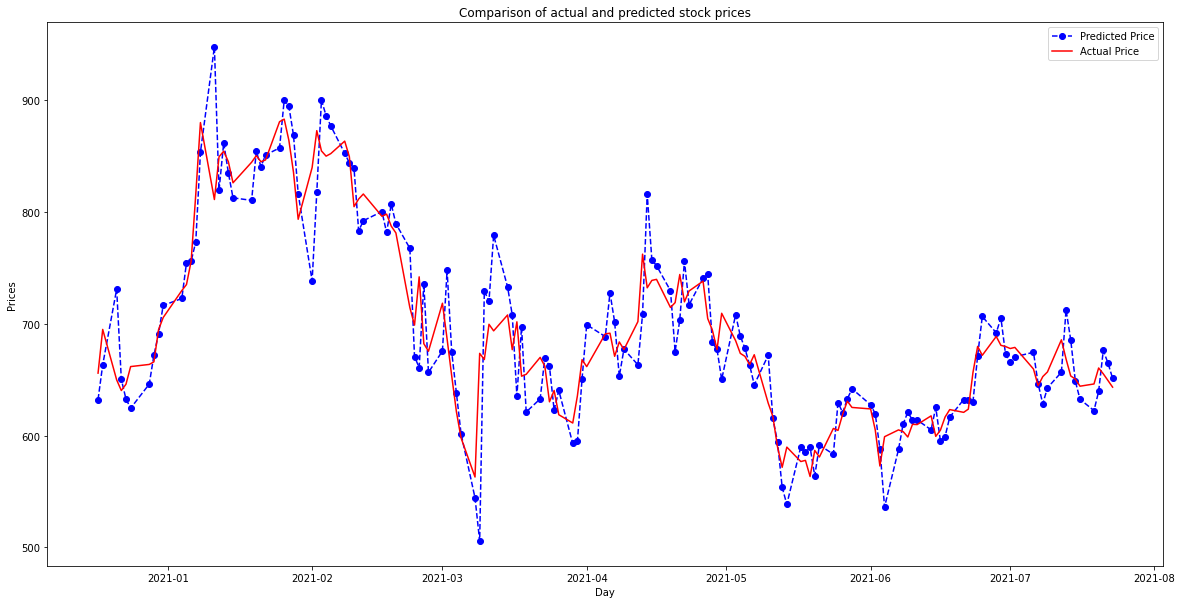

In [169]:
test_set = data[int(len(data)*0.7):].index
plt.figure(figsize=(20,10))
plt.plot(test_set, predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set, test_data, color='red', label='Actual Price')
plt.title('Comparison of actual and predicted stock prices')
plt.xlabel('Day')
plt.ylabel('Prices')
plt.legend()
plt.show()

### Training and testing the SARIMA model

In [170]:
history_of_train = [x for x in training_data]
predictions = []
test_records = len(test_data)
for times in range(test_records):
    sarima = SARIMAX(history_of_train, order=(4,4,0))
    sarima_fit = sarima.fit(disp=0)
    output = sarima_fit.forecast()
    pred = output[0]
    predictions.append(pred)
    test_value = test_data[times]
    history_of_train.append(test_value)

NormaltestResult(statistic=91.17030075084581, pvalue=1.5944860912212657e-20)


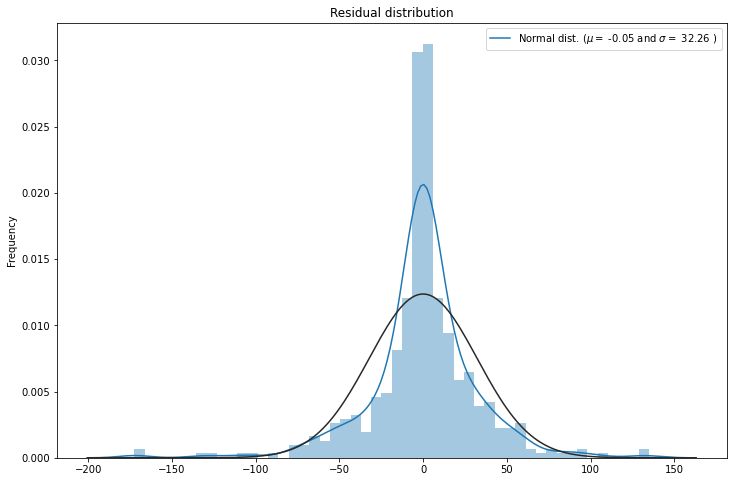

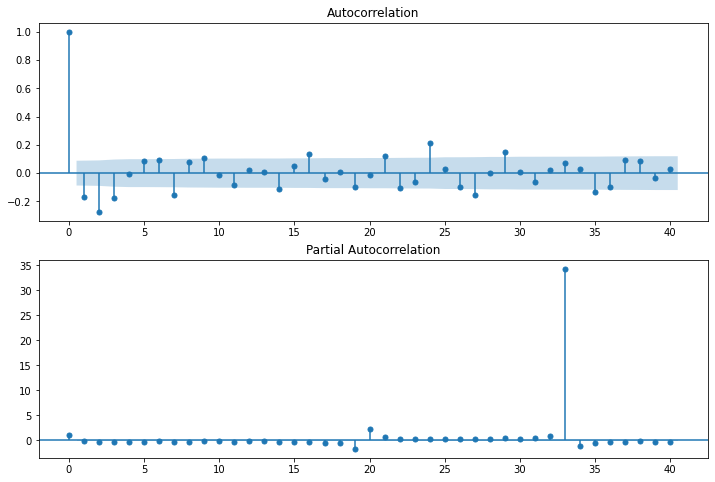

In [171]:
residual_plot(sarima_fit)

### Evaluation of sarima Model on Test data

### R2

In [172]:
sarima_test_rs=r2_score(test_data, predictions)
print('R Squared : ', round(sarima_test_rs,3))

R Squared :  0.667


### MSE

In [173]:
sarima_test_mse=mean_squared_error(test_data, predictions)
print('Mean Squared Error: ', round(sarima_test_mse,3))

Mean Squared Error:  2297.607


### MAE

In [174]:
sarima_test_MAE=mean_absolute_error(test_data, predictions)
print('Mean Absolute Error: ', round(sarima_test_MAE,3))

Mean Absolute Error:  34.505


### Predictions and Actual Stock Price

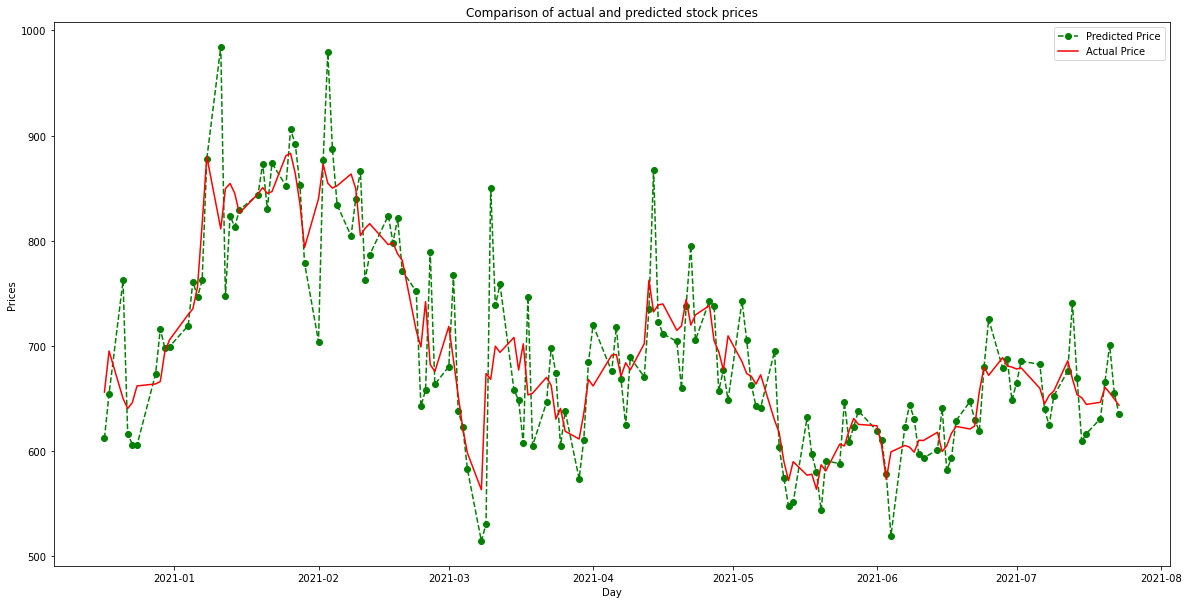

In [175]:
test_set = data[int(len(data)*0.7):].index
plt.figure(figsize=(20,10))
plt.plot(test_set, predictions, color='green', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set, test_data, color='red', label='Actual Price')
plt.title('Comparison of actual and predicted stock prices')
plt.xlabel('Day')
plt.ylabel('Prices')
plt.legend()
plt.show()

# Comparison of all algorithms Results on R2 score

In [176]:
x = PrettyTable()
print('\n')
print("Comparison of all algorithms")
x.field_names = ["Model", "R2 Score"]


x.add_row(["Arima Algorithm", round(arima_test_rs,3)])
x.add_row(["SARIMA Algorithm",  round(sarima_test_rs,3)])


print(x)
print('\n')



Comparison of all algorithms
+------------------+----------+
|      Model       | R2 Score |
+------------------+----------+
| Arima Algorithm  |  0.821   |
| SARIMA Algorithm |  0.667   |
+------------------+----------+




# Comparison of all algorithms Results on MSE score

In [177]:
x = PrettyTable()
print('\n')
print("Comparison of all algorithms")
x.field_names = ["Model", "MSE score"]


x.add_row(["Arima Algorithm", round(arima_test_mse,3)])
x.add_row(["SARIMA Algorithm",  round(sarima_test_mse,3)])


print(x)
print('\n')



Comparison of all algorithms
+------------------+-----------+
|      Model       | MSE score |
+------------------+-----------+
| Arima Algorithm  |  1236.471 |
| SARIMA Algorithm |  2297.607 |
+------------------+-----------+




# Comparison of all algorithms Results on MAE score

In [178]:
x = PrettyTable()
print('\n')
print("Comparison of all algorithms")
x.field_names = ["Model", "MAE score"]


x.add_row(["Arima Algorithm", round(arima_test_MAE,3)])
x.add_row(["SARIMA Algorithm",  round(sarima_test_MAE,3)])

print(x)
print('\n')



Comparison of all algorithms
+------------------+-----------+
|      Model       | MAE score |
+------------------+-----------+
| Arima Algorithm  |   25.451  |
| SARIMA Algorithm |   34.505  |
+------------------+-----------+




# Graph of MSE of each algorithm

<AxesSubplot:xlabel='Algorithm'>

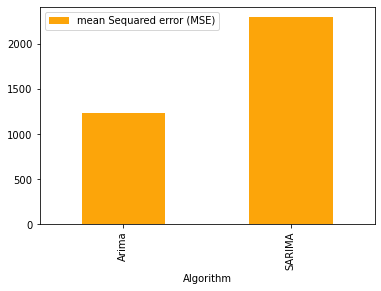

In [179]:
Result_Comp = pd.DataFrame({'Algorithm':['Arima'], 'mean Squared error (MSE)': [arima_test_mse]})
Result_Comp1 = pd.DataFrame({'Algorithm':['SARIMA'], 'mean Squared error (MSE)': [sarima_test_mse]})

Result_Comp = pd.concat([Result_Comp, Result_Comp1])
Result_Comp.set_index("Algorithm",drop=True,inplace=True)
color = cm.inferno_r(np.linspace(.2, .4, 6))
Result_Comp.plot(kind='bar',figsize=(6, 4),stacked=True, color=color, legend=True)

# Graph of R2 of each algorithm

<AxesSubplot:xlabel='Algorithm'>

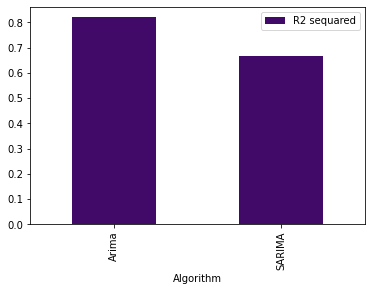

In [180]:
Result_Comp = pd.DataFrame({'Algorithm':['Arima'], 'R2 sequared': [arima_test_rs]})
Result_Comp1 = pd.DataFrame({'Algorithm':['SARIMA'], 'R2 sequared': [sarima_test_rs]})

Result_Comp = pd.concat([Result_Comp, Result_Comp1])
Result_Comp.set_index("Algorithm",drop=True,inplace=True)
color = cm.inferno_r(np.linspace(0.8, 0.5, 2))
Result_Comp.plot(kind='bar', figsize=(6, 4),color=color)

# Graph of MAE of each algorithm

<AxesSubplot:xlabel='Algorithm'>

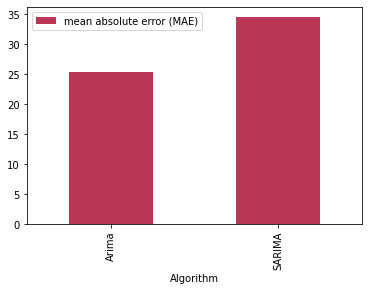

In [181]:
Result_Comp = pd.DataFrame({'Algorithm':['Arima'],'mean absolute error (MAE)': [arima_test_MAE]})
Result_Comp1 = pd.DataFrame({'Algorithm':['SARIMA'], 'mean absolute error (MAE)': [sarima_test_MAE]})

Result_Comp = pd.concat([Result_Comp, Result_Comp1])
Result_Comp.set_index("Algorithm",drop=True,inplace=True)
color = cm.inferno_r(np.linspace(0.5, 0.2, 7))
Result_Comp.plot(kind='bar', figsize=(6, 4),color=color)

### Now going to train Sarima on all data and then will fo FORECASTING

In [73]:
Sarima = SARIMAX(data['Close'],order=(4,1,0),seasonal_order=(1,1,1,12),enforce_invertibility=False, enforce_stationarity=False)
Sarima = Sarima.fit()

### FORECASTING

In [74]:
predictions = Sarima.predict(start=len(data), end= len(data)+42, dynamic= True)
predictions

2517    645.512149
2518    645.090782
2519    645.771070
2520    647.106213
2521    646.974461
2522    645.839889
2523    647.183105
2524    646.461312
2525    647.658278
2526    646.698264
2527    647.276342
2528    648.342414
2529    649.711003
2530    649.864855
2531    651.243937
2532    652.707020
2533    652.575902
2534    651.512229
2535    652.886269
2536    652.164216
2537    653.361343
2538    652.406906
2539    652.987826
2540    654.056451
2541    655.425219
2542    655.579418
2543    656.958754
2544    658.421916
2545    658.290821
2546    657.227177
2547    658.601230
2548    657.879179
2549    659.076307
2550    658.121872
2551    658.702793
2552    659.771420
2553    661.140188
2554    661.294387
2555    662.673722
2556    664.136884
2557    664.005790
2558    662.942145
2559    664.316198
Name: predicted_mean, dtype: float64

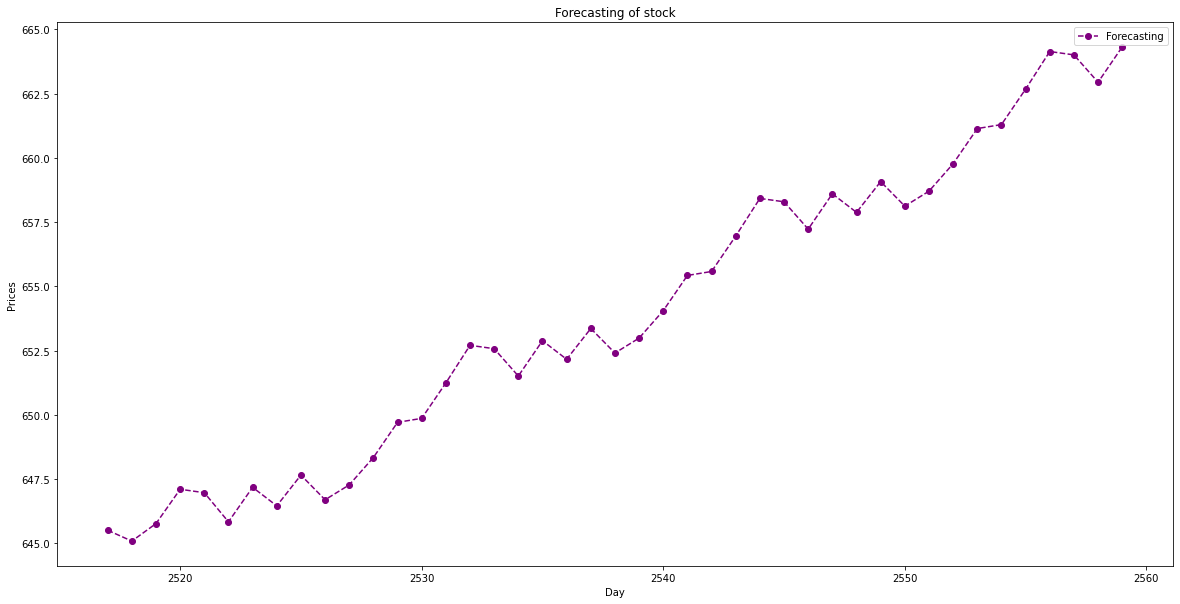

In [75]:
pred=pd.DataFrame(predictions)
pred=pred.rename(columns={'predicted_mean':'Forecasting'})
plt.figure(figsize=(20,10))
plt.plot(pred, color='purple', marker='o', linestyle='dashed',label='Forecasting')
plt.title('Forecasting of stock')
plt.xlabel('Day')
plt.ylabel('Prices')
plt.legend()
plt.show()